# Course 3684 – Advanced Topics in Machine Learning

<br>

# Home Assignment #1
## Ensemble Learning practical work

<hr>

### General instructions:

1. Submission is individual.
2. Submission must include python code and a written report.
3. You may use external libraries. Specify all required libraries in a proper manner.
4. Your code must be reproducible. Code that will not run will result in a grade reduction.
5. Your report should be clear, coherent, and concise. The report should not exceed 10 pages.
6. Invest thoughts and considerations to the way you choose to present data and experimental
results.
7. All figure and plots should include captions, labels and data units. Pay attention to data
visualization guidelines.
8. Make sure to use correct ML methodologies and justify your selections (split the data to
train/test, tune hyperparameters, report relevant performance measures).

### Assignment tasks:
The goal of this assignment is to practice the use of ensemble methods for classification problems.
1. Choose one of the following datasets:
    - Telco customer churn
    - Default of credit card
    - Hotel booking demand
2. Explore the dataset and its properties using standard Exploratory Data Analysis methods
3. Define a classification problem based on the chosen dataset.
4. Perform analysis of the performance of different classification algorithms on the dataset.
(Decision trees, Random Forests, Bagging, Boosting, etc.).
5. Demonstrate different ML concepts that were covered in class using the dataset
(Overfitting, Generalization, Bias/Variance, etc.)

<br>

Summarize all your work in a scientific/professional report.

<hr>

<br><br><br><br>

### Imports

In [ ]:
!pip install --quiet pycountry

In [ ]:
import os
import sys

from zipfile import ZipFile


import numpy as np
import pandas as pd


import seaborn as sns
import pycountry as pc

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier

pd.options.display.max_columns = None

In [ ]:
from google.colab import drive  
_ = drive.mount(r'/content/drive',force_remount=True) 
data_dir = os.getcwd() + '/drive/My Drive/IDC/ATML/'
os.listdir(data_dir)

Mounted at /content/drive


['archive.zip', 'Assignment_1.ipynb']

# Dataset

Downloaded the [dataset](https://www.kaggle.com/jessemostipak/hotel-booking-demand/download) to local memory from Kaggle and uploaded it. And unzipping it:


In [ ]:
dataset_dir = 'dataset'

zf = ZipFile(data_dir + 'archive.zip', 'r')
zf.extractall(dataset_dir)
zf.close()

Look at the downloaded files

In [ ]:
!ls dataset

hotel_bookings.csv


Read CSV to dataframes

In [ ]:
df = pd.read_csv(dataset_dir + '/hotel_bookings.csv')
df.shape

(119390, 32)

# Data Preprocessing 

### Dealing with Missing Values
Check if our data contains any missing values.  
Find the missing value, show the total null values for each column and sort it in descending order

In [ ]:
df.isnull().sum().sort_values(ascending=False)

company                           112593
agent                              16340
country                              488
children                               4
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
hotel                                  0
previous_cancellations                 0
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status                     0
previous_bookings_not_canceled         0
is_repeated_guest                      0
is_canceled                            0
distribution_channel                   0
market_segment                         0
meal                                   0
babies                                 0
adults                                 0
stays_in_week_ni

Fill ID missing values with zeros:

In [ ]:
df.company.fillna( 0, inplace=True) 
df.agent.fillna( 0, inplace=True)

Fill numeric missing values with the mean value:

In [ ]:
df.children.fillna( round(df.children.mean()),inplace=True)

Fill categorical missing values with the most popular values:

In [ ]:
df.country.fillna( df.country.mode().to_string(), inplace=True)

Let's drop the rows that does not make sense, meaning that numbers of guests is none:

In [ ]:
index_to_drop = df[df.adults+df.babies+df.children==0].index
df.drop(index_to_drop,inplace=True)

### Converting Datatype
Let’s check the datatype of each column in our dataset.

In [ ]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

Changing Integer values to `int64` type:

In [ ]:
df[['children', 'company', 'agent']] = df[['children', 'company', 'agent']].astype('int64')

# Exploratory Data Analysis

Create two helper functions so I won't have to rewrite it:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def get_count(series, limit=None):
    
    '''
    INPUT:
        series: Pandas Series (Single Column from DataFrame)
        limit:  If value given, limit the output value to first limit samples.
    OUTPUT:
        x = Unique values
        y = Count of unique values
    '''
    
    if limit != None:
        series = series.value_counts()[:limit]
    else:
        series = series.value_counts()
    
    x = series.index
    y = series/series.sum()*100
    
    return x.values,y.values


def plot(x, y, x_label=None,y_label=None, title=None, figsize=(7,5), type='bar'):
    
    '''
    INPUT:
        x:        Array containing values for x-axis
        y:        Array containing values for y-axis
        x_lable:  String value for x-axis label
        y_lable:  String value for y-axis label
        title:    String value for plot title
        figsize:  tuple value, for figure size
        type:     type of plot (default is bar plot)
        
    OUTPUT:
        Display the plot
    '''
    
    sns.set_style('darkgrid')
    
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    if x_label != None:
        ax.set_xlabel(x_label)
    
    if y_label != None:
        ax.set_ylabel(y_label)
        
    if title != None:
        ax.set_title(title)
    
    if type == 'bar':
        sns.barplot(x,y, ax = ax)
    elif type == 'line':
        sns.lineplot(x,y, ax = ax, sort=False)
        
    
    plt.show();

###I will try to answer the following Questions
- How Many Booking Were Cancelled?
- What is the booking ratio between Resort Hotel and City Hotel?
- What is the percentage of booking for each year?
- Which is the busiest month for hotels?
- From which country most guests come?
- How Long People Stay in the hotel?
- Which was the most booked accommodation type (Single, Couple, Family)?

#### How Many Booking Were Cancelled?

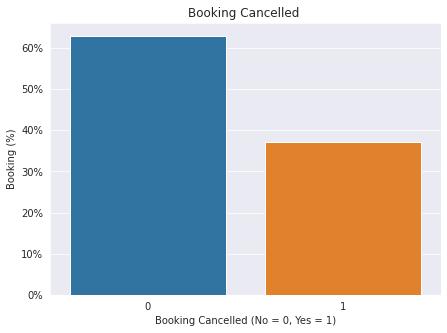

In [ ]:
x,y = get_count(df['is_canceled'])
plot(x,y, x_label='Booking Cancelled (No = 0, Yes = 1)', y_label='Booking (%)',title='Booking Cancelled ');

Bookings got canceled 37% of the time. While booking guest did checkd-in (did not cancel the booking ) almost 63% of the time.

I'll focus on the non cancelled orders:

In [ ]:
df_not_canceled = df[df['is_canceled'] == 0]

#### What is the booking ratio between Resort Hotel and City Hotel?

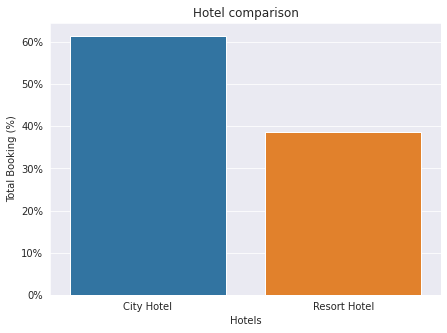

In [ ]:
x,y = get_count(df_not_canceled['hotel'])
plot(x,y, x_label='Hotels', y_label='Total Booking (%)', title='Hotel comparison')

More than 60% of the population booked the City hotel.

#### What is the percentage of booking for each year?

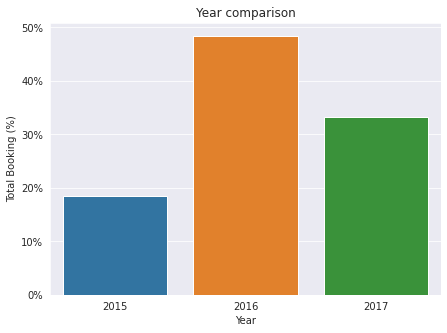

In [ ]:
x,y = get_count(df_not_canceled['arrival_date_year'])
plot(x,y, x_label='Year', y_label='Total Booking (%)', title='Year comparison')

More than double bookings were made in 2016, compared to the previous year. But the bookings decreased by almost 15% the next year.

Let’s separate it by the hotel and then plot the diagram. 

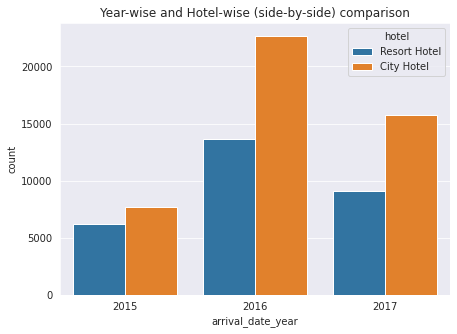

In [ ]:
plt.subplots(figsize=(7,5))
plt.title('Year-wise and Hotel-wise (side-by-side) comparison')
sns.countplot(x='arrival_date_year', hue='hotel',  data=df_not_canceled);

#### Which is the busiest month for hotels?

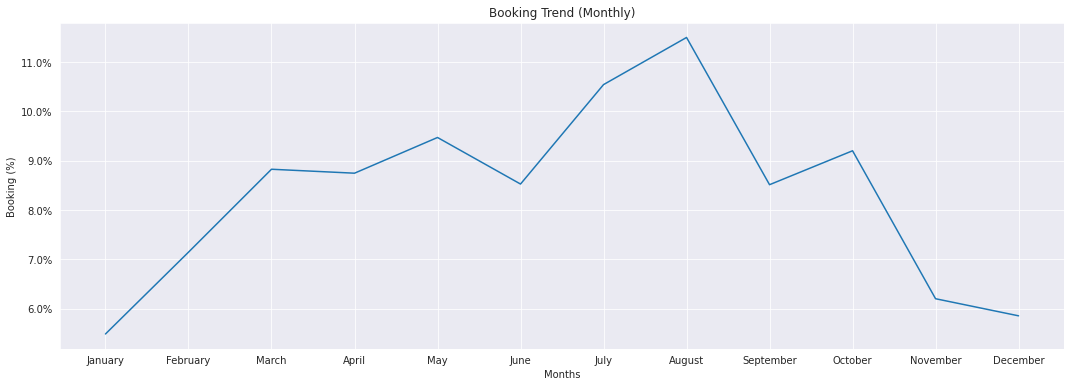

In [ ]:
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
             'October', 'November', 'December']

sorted_months = df_not_canceled['arrival_date_month'].value_counts().reindex(new_order)

x = sorted_months.index
y = sorted_months/sorted_months.sum()*100


#sns.lineplot(x, y.values)
plot(x, y.values, x_label='Months', y_label='Booking (%)', title='Booking Trend (Monthly)', type='line', figsize=(18,6))

As we can see most bookings were made from July to August. And the least bookings were made at the start and end of the year.

Let’s separate the data for each hotel type and then see the trend.


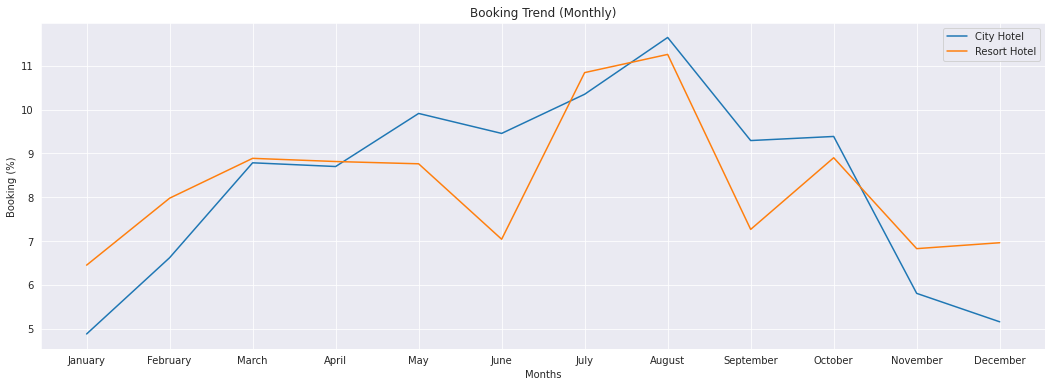

In [ ]:
## Order of months
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
             'November', 'December']


## Select only City Hotel
sorted_months = df_not_canceled.loc[df.hotel=='City Hotel' ,'arrival_date_month'].value_counts().reindex(new_order)

x1 = sorted_months.index
y1 = sorted_months/sorted_months.sum()*100



## Select only Resort Hotel
sorted_months = df_not_canceled.loc[df.hotel=='Resort Hotel' ,'arrival_date_month'].value_counts().reindex(new_order)

x2 = sorted_months.index
y2 = sorted_months/sorted_months.sum()*100

## Draw the line plot

fig, ax = plt.subplots(figsize=(18,6))

ax.set_xlabel('Months')
ax.set_ylabel('Booking (%)')
ax.set_title('Booking Trend (Monthly)')


sns.lineplot(x1, y1.values, label='City Hotel', sort=False)
sns.lineplot(x1, y2.values, label='Resort Hotel', sort=False)

plt.show()

We can see the trend is kind of similar with a small difference. Resort has more bookings at the start and end of the year, and lower booking in June and September.

#### From which country most guests come?

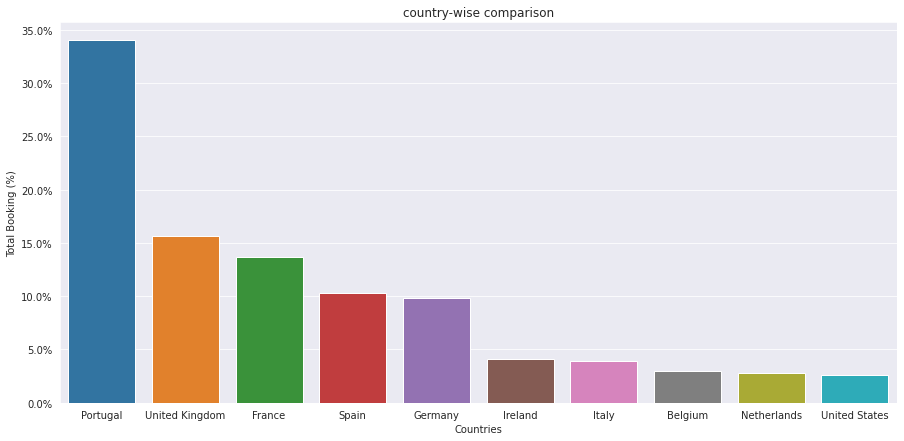

In [ ]:
x,y = get_count(df_not_canceled['country'], limit=10)
country_name = [pc.countries.get(alpha_3=name).name for name in x]
plot(country_name,y, x_label='Countries', y_label='Total Booking (%)', title='country-wise comparison', figsize=(15,7))

Portugal, UK and France, Spain and Germany are the top countries from most guests come, more than 80% come from these 5 countries.

#### How Long People Stay in the hotel?

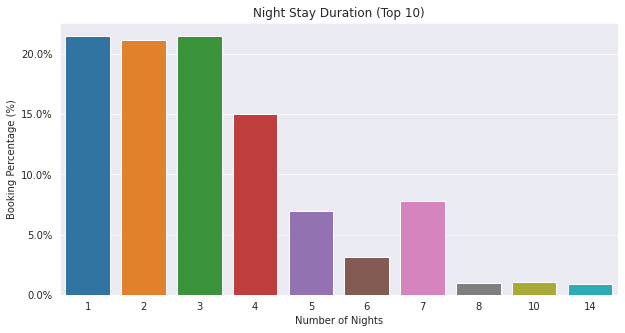

In [ ]:
total_nights = df_not_canceled['stays_in_weekend_nights']+ df_not_canceled['stays_in_week_nights']

x,y = get_count(total_nights, limit=10)
plot(x,y, x_label='Number of Nights', y_label='Booking Percentage (%)', title='Night Stay Duration (Top 10)', figsize=(10,5))

Most people stay for one, two, or three. More than 60% of guests come under these three options.

Let’s see the stay duration trend for each hotel type.

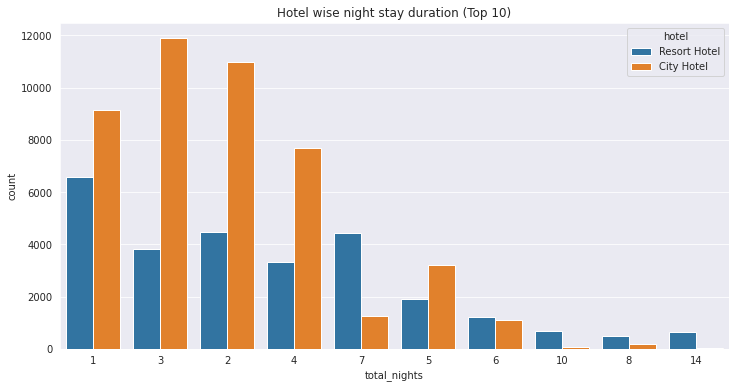

In [ ]:
df_not_canceled.loc[:,'total_nights'] = df_not_canceled['stays_in_weekend_nights']+ df_not_canceled['stays_in_week_nights']

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel('No of Nights')
ax.set_ylabel('No of Nights')
ax.set_title('Hotel wise night stay duration (Top 10)')
sns.countplot(x='total_nights', hue='hotel', data=df_not_canceled, order = df_not_canceled.total_nights.value_counts().iloc[:10].index, ax=ax);

For Resort hotel, the most popular stay duration is three, two, one, and four days respectively.
For City hotel, most popular stay duration is one, two, seven(week), and three respectively.

#### Which was the most booked accommodation type (Single, Couple, Family)?

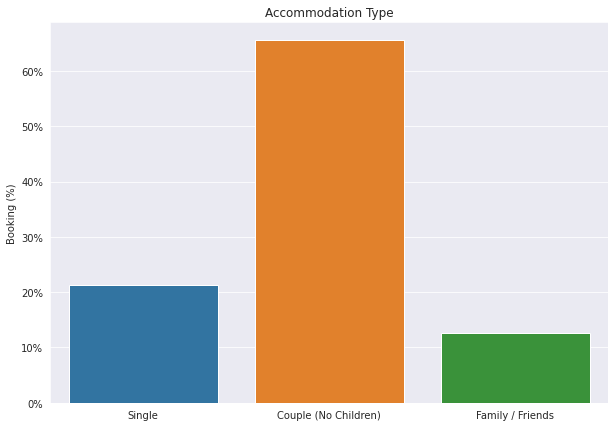

In [ ]:
## Select single, couple, multiple adults and family
single   = df_not_canceled[(df_not_canceled.adults==1) & (df_not_canceled.children==0) & (df_not_canceled.babies==0)]
couple   = df_not_canceled[(df_not_canceled.adults==2) & (df_not_canceled.children==0) & (df_not_canceled.babies==0)]
family   = df_not_canceled[df_not_canceled.adults + df_not_canceled.children + df_not_canceled.babies > 2]


## Make the list of Category names, and their total percentage
names = ['Single', 'Couple (No Children)', 'Family / Friends']
count = [single.shape[0],couple.shape[0], family.shape[0]]
count_percent = [x/df_not_canceled.shape[0]*100 for x in count]


## Draw the curve
plot(names,count_percent,  y_label='Booking (%)', title='Accommodation Type', figsize=(10,7))

Couple (or 2 adults) is the most popular accommodation type. So hotels can make plans accordingly.

<br><br><br><br><br><br>

# Feature Selection and Feature Engineering


Let's make the copy of the dataset

In [ ]:
df_subset = df.copy()

Let's make the new column which contain 1 if guest received the same room which was reserved otherwise 0


In [ ]:
df_subset['Room'] = 0
df_subset.loc[ df_subset['reserved_room_type'] == df_subset['assigned_room_type'] , 'Room'] = 1

Let's make the new column which contain 1 if the guest has cancelled more booking in the past than the number of booking he did not cancel, otherwise 0

In [ ]:
df_subset['net_cancelled'] = 0
df_subset.loc[ df_subset['previous_cancellations'] > df_subset['previous_bookings_not_canceled'] , 'net_cancelled'] = 1

Let's remove the less important features


In [ ]:
df_subset = df_subset.drop(['arrival_date_year','arrival_date_week_number','arrival_date_day_of_month',
                            'arrival_date_month','assigned_room_type','reserved_room_type','reservation_status_date',
                            'previous_cancellations','previous_bookings_not_canceled'],axis=1)

Let's remove `reservation_status` column, because it tells us if booking was cancelled 

In [ ]:
df_subset = df_subset.drop(['reservation_status'], axis=1)

Let's plot the heatmap to see correlation with columns


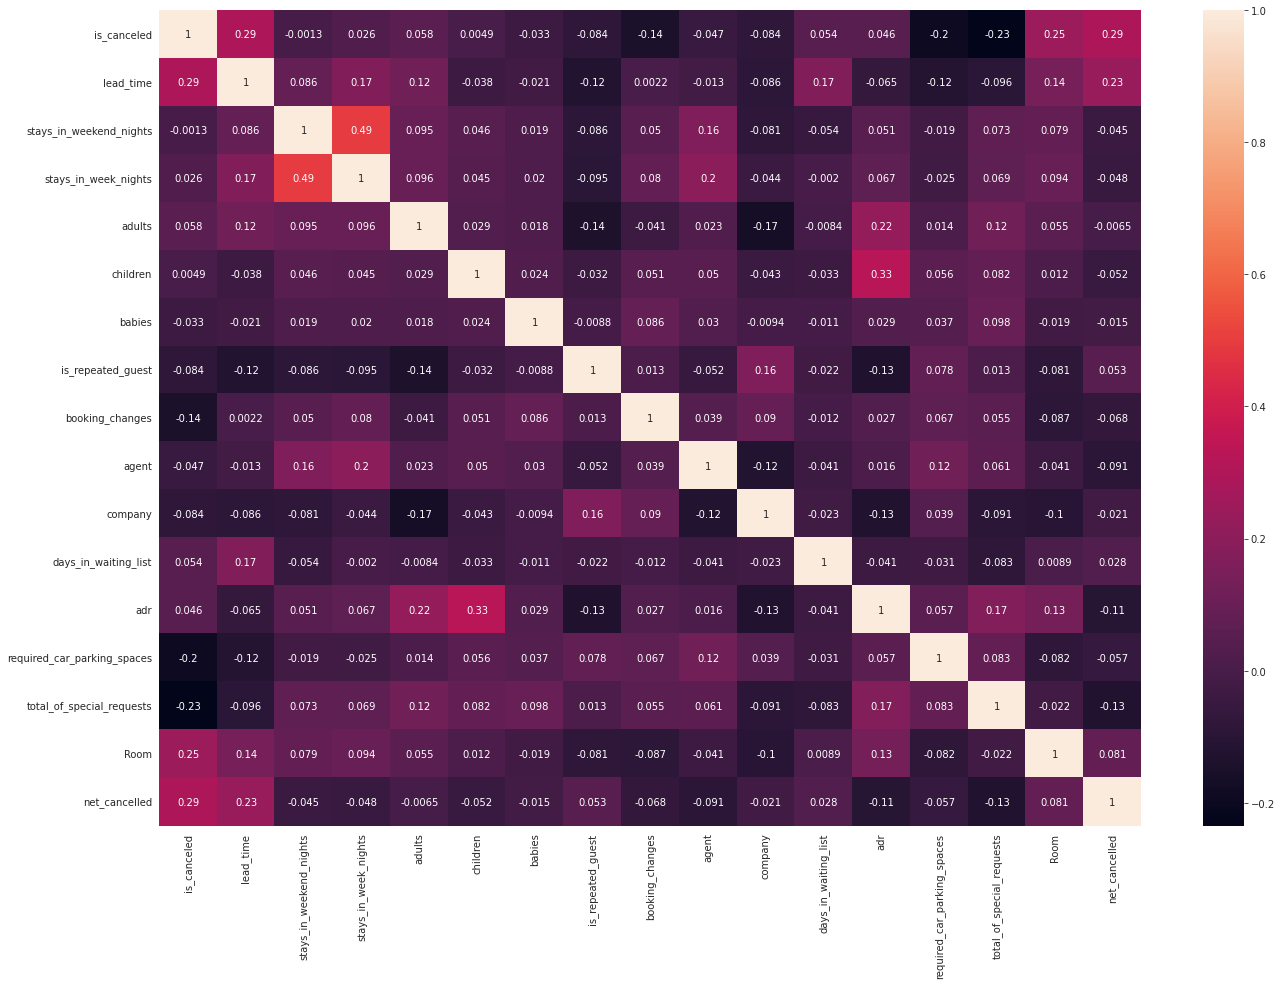

In [ ]:
fig, ax = plt.subplots(figsize=(22,15))
sns.heatmap(df_subset.corr(), annot=True, ax=ax);

We can see our new features, `Room` and `net_cancelled` have a higher correlation with `is_cancelled` than most of the other columns.

<br><br><br>

# Modeling

#### Converting Categorical variables to Numerical
Let’s convert categorical values into numerical form.


In [ ]:
df.shape, df_subset.shape

((119210, 32), (119210, 24))

In [ ]:
def transform(dataframe):
    ## Import LabelEncoder from sklearn
    le = LabelEncoder()
    
    ## Select all categorcial features
    categorical_features = list(dataframe.columns[dataframe.dtypes == object])
    
    ## Apply Label Encoding on all categorical features
    dataframe[categorical_features] =  dataframe[categorical_features].apply(lambda x: le.fit_transform(x))

    return dataframe

df_subset_num = transform(df_subset)

#### Train Test Split
Now let’s split the dataset into train and test. The default size of the split ratio is 3:1


In [ ]:
def data_split(df, label):

    X = df.drop(label, axis=1)
    Y = df[label]

    x_train, x_test, y_train, y_test = train_test_split(X,Y,random_state=0)
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = data_split(df_subset_num, 'is_canceled')
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((89407, 23), (29803, 23), (89407,), (29803,))

#### Model Training

In [ ]:
df_results = pd.DataFrame(columns=['CLASIFIER','TRAIN_TIME','INFERENCE_TIME'])

In [ ]:
from time import time

models = { 'DTC' : DecisionTreeClassifier(random_state=0),
           'RFC' : RandomForestClassifier(random_state=0), 
           'BC' : BaggingClassifier(random_state=0), 
           'ABC' : AdaBoostClassifier(random_state=0)
          }

df_results['CLASIFIER'] = models.keys()

def train_model(clf):
  t = time()
  clf.fit(x_train,y_train)
  return time()-t

s = x_train.sample()
def get_inference_time(clf):
  global s
  t = time()
  clf.predict(s)
  return time()-t

df_results['TRAIN_TIME'] = df_results['CLASIFIER'].apply(lambda x: train_model(models[x]))
df_results['TRAIN_TIME'] = df_results['TRAIN_TIME']/df_results['TRAIN_TIME'].max()

df_results['INFERENCE_TIME'] = df_results['CLASIFIER'].apply(lambda x: get_inference_time(models[x]) )
df_results['INFERENCE_TIME'] = df_results['INFERENCE_TIME']/df_results['INFERENCE_TIME'].max()



df_results

,CLASIFIER,TRAIN_TIME,INFERENCE_TIME
0,DTC,0.076675,0.056169
1,RFC,1.000000,0.760935
2,BC,0.315284,0.104757
3,ABC,0.328254,1.000000


In [ ]:
df_results['INFERENCE_TIME'] = df_results['INFERENCE_TIME']/df_results['INFERENCE_TIME'].max()


#### Model Evaluation

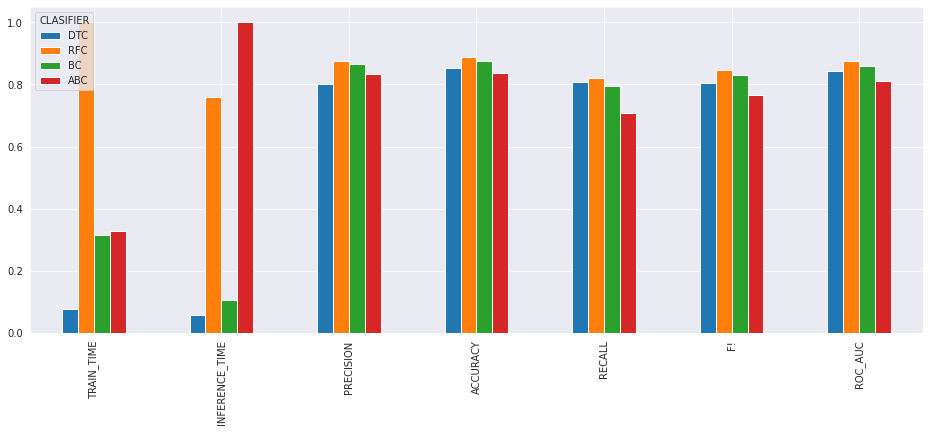

In [ ]:
from sklearn.metrics import precision_score,accuracy_score, recall_score, f1_score, roc_auc_score


metrics = {'PRECISION' : precision_score, 'ACCURACY' : accuracy_score, 'RECALL' : recall_score, 'F!': f1_score, 'ROC_AUC' : roc_auc_score}


ys_pred = {}
for k,m in models.items():
  ys_pred[k] = m.predict(x_test)

for k,m in metrics.items():
  df_results[k] = df_results['CLASIFIER'].apply(lambda x: metrics[k](y_test,ys_pred[x]) )

df_results.set_index('CLASIFIER').T.plot(kind='bar', figsize=(16, 6))

While the **vanila** `Random Forest Classifier` has the worst time performence (compare to the others), it has the best metric scores - ACC,Recall, etc.  
So let's choose it for the next part.



#### ML concepts:

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
from sklearn.metrics import roc_curve, auc

from sklearn.decomposition import PCA

from sklearn.datasets import make_blobs


Plot function

In [ ]:
pca = PCA(n_components=2)

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

def plot_db(ax,m):
  plot_step = 5

  # define the model
  model = RandomForestClassifier(random_state=0)

  # fit the model
  model.fit(x_train_pca, m.predict(x_train))

  # define bounds of the domain
  min1, max1 = x_train_pca[:, 0].min()-1, x_train_pca[:, 0].max()+1
  min2, max2 = x_train_pca[:, 1].min()-1, x_train_pca[:, 1].max()+1

  # define the x and y scale
  x1grid = np.arange(min1, max1, plot_step)
  x2grid = np.arange(min2, max2, plot_step)

  # create all of the lines and rows of the grid
  xx, yy = np.meshgrid(x1grid, x2grid)

  # flatten each grid to a vector
  r1, r2 = xx.flatten(), yy.flatten()
  r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

  # horizontal stack vectors to create x1,x2 input for the model
  grid = np.hstack((r1,r2))

  # make predictions for the grid
  yhat = model.predict(grid)

  # reshape the predictions back into a grid
  zz = yhat.reshape(xx.shape)

  # plot the grid of x, y and z values as a surface
  ax.contourf(xx, yy, zz, cmap='Paired')

  # create scatter plot for samples from each class
  # for class_value in range(2):
  #     # get row indexes for samples with this class
  #     row_ix = np.where(y_train == class_value)
  #     # create scatter of these samples
  #     plt.scatter(x_train_pca[row_ix, 0], x_train_pca[row_ix, 1], cmap='Paired',marker='.')

##### Generalization and Overfitting

Generalization is a term used to describe a model’s ability to react to new data. That is, after being trained on a training set, a model can digest new data and make accurate predictions. 

**A model’s ability to generalize is central to the success of a model.**   

If a model has been trained too well on training data, it will be unable to generalize. It will make inaccurate predictions when given new data, making the model useless even though it is able to make accurate predictions for the training data.  
**This is called overfitting.**  

The inverse is also true. 
Underfitting happens when a model has not been trained enough on the data.  
In the case of underfitting, it makes the model just as useless and it is not capable of making accurate predictions, even with the training data.

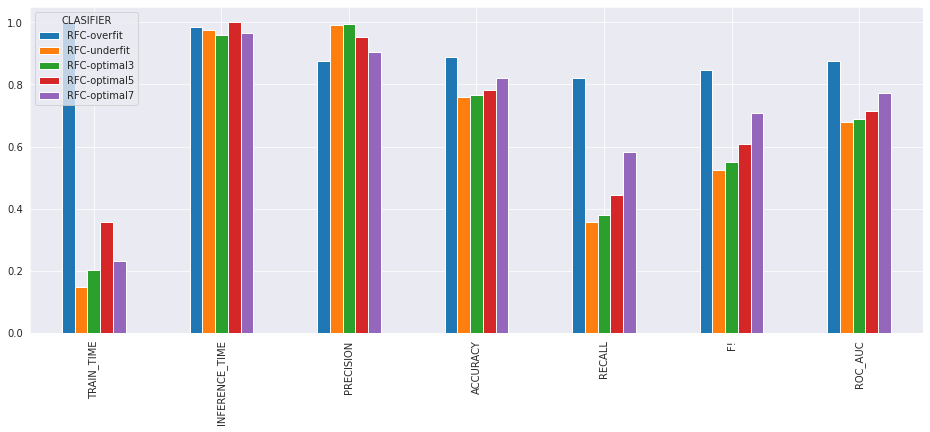

In [ ]:
from time import time

df_rfc = pd.DataFrame(columns=['CLASIFIER','TRAIN_TIME','INFERENCE_TIME'])
models = { 'RFC-overfit'  : RandomForestClassifier(max_depth=None, random_state=0), 
           'RFC-underfit' : RandomForestClassifier(max_depth=1, random_state=0), 
           'RFC-max_depth=3'  : RandomForestClassifier(max_depth=3, random_state=0),
           'RFC-max_depth=5'  : RandomForestClassifier(max_depth=5, random_state=0),
           'RFC-max_depth=7'  : RandomForestClassifier(max_depth=7, random_state=0), 

           }

df_rfc['CLASIFIER'] = models.keys()

def train_model(clf):
  t = time()
  clf.fit(x_train,y_train)
  return time()-t

s = x_train.sample()
def get_inference_time(clf):
  global s
  t = time()
  clf.predict(s)
  return time()-t

df_rfc['TRAIN_TIME'] = df_rfc['CLASIFIER'].apply(lambda x: train_model(models[x]))
df_rfc['TRAIN_TIME'] = df_rfc['TRAIN_TIME']/df_rfc['TRAIN_TIME'].max()

df_rfc['INFERENCE_TIME'] = df_rfc['CLASIFIER'].apply(lambda x: get_inference_time(models[x]) )
df_rfc['INFERENCE_TIME'] = df_rfc['INFERENCE_TIME']/df_rfc['INFERENCE_TIME'].max()

ys_pred = {}
for k,m in models.items():
  ys_pred[k] = m.predict(x_test)

for k,m in metrics.items():
  df_rfc[k] = df_rfc['CLASIFIER'].apply(lambda x: metrics[k](y_test,ys_pred[x]) )

df_rfc.set_index('CLASIFIER').T.plot(kind='bar', figsize=(16, 6))

Let's plot each model decision boundaries:

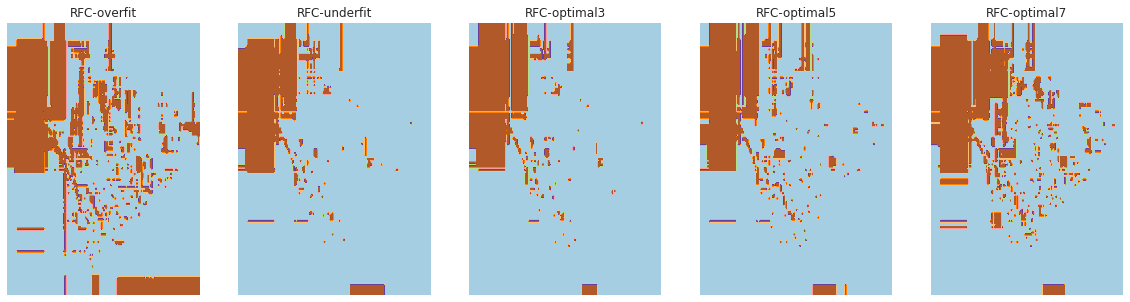

In [ ]:


fig, axes = plt.subplots(1,5,figsize=(20,5));

for m,ax in zip(models,axes):
  plot_db(ax,models[m])
  ax.axis('off')
  ax.set_title(m)

It's easy to see how the bigger the `max_depth` is, the bounderies will become more overfit, and more specific to some of the datapoints.  


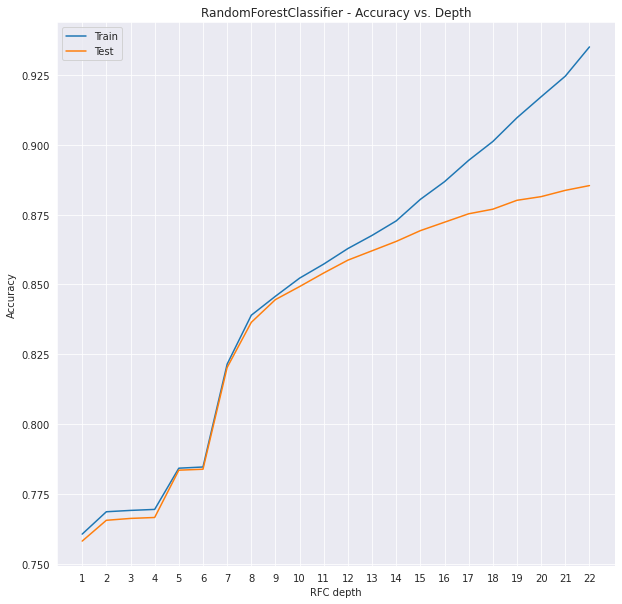

In [ ]:
scoresDT = {}
for depth in range(1,23):
    model_name = 'RFC-max_depth=' + str(depth)
    classifier = RandomForestClassifier(random_state=0,max_depth=depth)
    classifier.fit(x_train, y_train)
    scoresDT[depth] = {'train':classifier.score(x_train,y_train), 'test':classifier.score(x_test,y_test)}

plt.figure(figsize=(10,10))
ax = plt.subplot()
t = list(scoresDT.keys())

ax.plot(t,[s['train'] for s in scoresDT.values()],label = 'Train')
ax.plot(t,[s['test'] for s in scoresDT.values()],label = 'Test')

ax.set_xticks(t)
ax.set_xticklabels(scoresDT.keys())

# ax.set_yticks(np.linspace(0,1-shift,num=5))
# ax.set_yticklabels([f'{v:.2f}' for v in np.linspace(shift,1,num=5)])

ax.set_xlabel('RFC depth')
ax.set_ylabel('Accuracy')
ax.set_title('RandomForestClassifier - Accuracy vs. Depth')
plt.legend();

After depth=10 , we can see how the improvment on the train set is higher than the improvment on the test set.  

Due to the efficient `feature engineering` each feature will contribute to the accuracy of the model over the data.


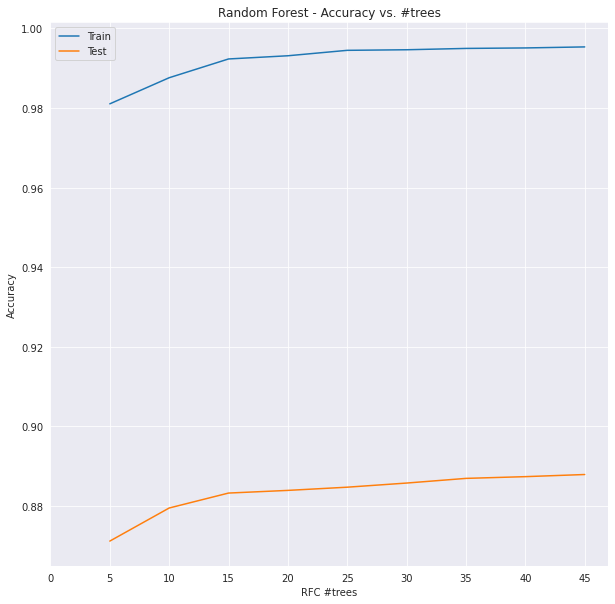

In [ ]:
scoresRF = {}
for trees in range(5,50,5):
    model_name = 'RF-' + str(trees)
    classifier = RandomForestClassifier(random_state=0, n_estimators=trees)
    classifier.fit(x_train, y_train)
    scoresRF[trees] = {'train':classifier.score(x_train,y_train), 'test':classifier.score(x_test,y_test)}

plt.figure(figsize=(10,10))
ax = plt.subplot()

t = np.linspace(0,max(scoresRF.keys()),10)
shift = 0.9

ax.plot(list(scoresRF.keys()),[s['train'] for s in scoresRF.values()],label = 'Train')
ax.plot(list(scoresRF.keys()),[s['test'] for s in scoresRF.values()],label = 'Test')
ax.set_xticks(t)

# ax.set_yticks(np.linspace(0,1-shift,num=5))
# ax.set_yticklabels([f'{v:.2f}' for v in np.linspace(shift,1,num=5)])

ax.set_xlabel('RFC #trees')
ax.set_ylabel('Accuracy')
ax.set_title('Random Forest - Accuracy vs. #trees')
plt.legend();

It's easy to see that after 15 and above trees the accuracy will stay about the same.  
And because the amout of trees affect directly on the time of training&inference, this sould be considered, and set to low as possible.

##### Bias & Veriance

To understand bias variance in random forest it is important to understand bias variance in decision trees. 

In a decision tree if the tree is shallow then it might have a high bias i.e underfitting.   
If the tree is too deep then it will have a high variance i.e overfitting. 

So to achieve a good bias variance trade-off in a decision tree you will have to do some hyper parameter tuning.

<br>

Random forest is an ensemble bagging technique where number of decision trees combine to give the result.   
The process is a combination of bootstrapping and aggregation. 



In [ ]:
import sys
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X_train = x_train
Y_train = y_train
X_test = x_test
Y_test = y_test

###################### Linear Regression #########################################################
# Note: The population data is inclusive of both test and train data
# Building a linear model on population data
population_linear_model = LinearRegression().fit(X_train, y_train)
y_hat_pop = population_linear_model.predict(X_test)

###################### Decision Tree #############################################################
# Building a Decision tree model on population data and obtaining predicion on test data
population_decision_tree = DecisionTreeRegressor(criterion='mse', min_samples_leaf=3).fit(X_train, y_train)
y_hat_pop_tree = population_decision_tree.predict(X_test)

###################### Bagging - Decision Tree ###################################################
# Building a Bagging model on population data and obtaining predicion on test data
population_bagging_model = BaggingRegressor().fit(X_train, y_train)
y_hat_pop_bagging = population_bagging_model.predict(X_test)


###################### Random Forest ###################################################
# Building a Random Forest model on population data and obtaining predicion on test data
population_randomForest_model = RandomForestRegressor().fit(X_train, y_train)
y_hat_pop_randomForest = population_randomForest_model.predict(X_test)

In [ ]:
# Method to compute the variance
def calculate_varaince_of_model(samplePredictions, y_test):
    predictions_mean_model = samplePredictions.mean(axis =1)
    colNames = samplePredictions.columns
    variance = np.zeros(len(colNames))
    i = 0
    for colName in colNames:
        variance[i] = np.mean(np.square(samplePredictions[colName] - predictions_mean_model))
        rmse = mean_squared_error(y_test, samplePredictions[colName])
        i += 1
    return round(np.mean(variance),3), round(np.mean(rmse),3)

In [ ]:
# Method to compute the bias
def calculate_bias_of_model(samplePredictions, y_hat_pop):
    return np.square((np.abs(samplePredictions.mean(axis=1) -y_hat_pop).mean()))

In [ ]:
# Note : Care has to be taken such that X_test should be a value, as per the previous block of codes
# Method to build linear moodel, gives, predictions as an output.
def samplePredForLinearRegression(X_train, y_train):
    sample_Linear_Model = LinearRegression().fit(X_train, y_train)
    return sample_Linear_Model.predict(X_test)

# Method to build linear moodel
def samplePredForDecisionTree(X_train, y_train):
    sample_Tree_Model = DecisionTreeRegressor(criterion='mse', min_samples_leaf=3).fit(X_train, y_train)
    return sample_Tree_Model.predict(X_test)
    
# Method to build Decision tree bagging model
def samplePredForDTBaggin(X_train, y_train):
    sample_bagging_Model = BaggingRegressor().fit(X_train, y_train)
    return sample_bagging_Model.predict(X_test)

# Method to build Random Forst model
def samplePredForRandomForest(X_train, y_train):
    sample_RandomForest_Model = RandomForestRegressor().fit(X_train, y_train)
    return sample_RandomForest_Model.predict(X_test)

# Method to build Ridge Regression model
def samplePredForRidgeRegression(X_train, y_train, alpha):
    sample_ridge_model = Ridge(alpha=alpha, normalize=True)
    sample_ridge_model.fit(X_train,y_train)
    return sample_ridge_model.predict(X_test)

In [ ]:
# it is the main method, which computes the bias and variance of various model
# Takes sampleCount - sample size and noOfModels - no of models that are to be built i.e. the no of times the samples are to
# be obtained from the population
def get_bias_variance(sampleCount, noOfModels):
    bias_variance_result = pd.DataFrame(columns=['sample_count','no_of_models','algorithm','bias','variance', 'mse'])
    print('Builds Linear Regression, Decision Tree, Bagging, Random Forest algorithms')
    print('Total No of models built is',str(noOfModels* 4))
    
    samplePredictionsLinearModel = pd.DataFrame()
    samplePredictionsTree = pd.DataFrame()
    samplePredictionsBagging = pd.DataFrame()
    samplePredictionsRandomForest = pd.DataFrame()
    
    with tqdm.tqdm(total=noOfModels, file=sys.stdout) as pbar:
        for i in range(0, noOfModels):
            pbar.set_description('Building Model : %d' % (1 + i))
            
            samplePredictionsLinearModel['sample'+str(i+1)] = samplePredForLinearRegression(X_train, y_train)
            samplePredictionsTree['sample'+str(i+1)] = samplePredForDecisionTree(X_train, y_train)
            samplePredictionsBagging['sample'+str(i+1)] = samplePredForDTBaggin(X_train, y_train)
            samplePredictionsRandomForest['sample'+str(i+1)] = samplePredForRandomForest(X_train, y_train)
            pbar.update(1)
    
    '''print('samplePredictionsLinearModel :', samplePredictionsLinearModel.shape)
    print('samplePredictionsTree :', samplePredictionsTree.shape)
    print('samplePredictionsBagging :', samplePredictionsBagging.shape)
    print('samplePredictionsRandomForest :', samplePredictionsRandomForest.shape)'''
    
    var_mse_linear_model = calculate_varaince_of_model(samplePredictionsLinearModel, y_test)
    var_mse_tree_model = calculate_varaince_of_model(samplePredictionsTree, y_test)
    var_mse_bagging_model = calculate_varaince_of_model(samplePredictionsBagging, y_test)
    var_mse_random_forest_model = calculate_varaince_of_model(samplePredictionsRandomForest, y_test)
    
    bias_linear_model = calculate_bias_of_model(samplePredictionsLinearModel, y_hat_pop)
    bias_tree_model = calculate_bias_of_model(samplePredictionsTree, y_hat_pop_tree)
    bias_bagging_model = calculate_bias_of_model(samplePredictionsBagging, y_hat_pop_bagging)
    bias_random_forest_model = calculate_bias_of_model(samplePredictionsRandomForest, y_hat_pop_randomForest)
    
    s_linear = pd.Series(data={'sample_count':sampleCount, 'no_of_models':noOfModels, 'algorithm':'LR',
                    'bias':bias_linear_model, 'variance' : var_mse_linear_model[0], 'mse' : var_mse_linear_model[1]}, name = 0)
    
    s_tree = pd.Series(data={'sample_count':sampleCount, 'no_of_models':noOfModels, 'algorithm':'DecisionTree',
                    'bias':bias_tree_model, 'variance' : var_mse_tree_model[0], 'mse' : var_mse_tree_model[1]}, name = 0)
    
    s_bagging = pd.Series(data={'sample_count':sampleCount, 'no_of_models':noOfModels, 'algorithm':'Bagging',
                    'bias':bias_bagging_model, 'variance' : var_mse_bagging_model[0], 'mse' : var_mse_bagging_model[1]}, name = 0)
    
    s_rf = pd.Series(data={'sample_count':sampleCount, 'no_of_models':noOfModels, 'algorithm':'RandomForest',
                    'bias':bias_random_forest_model, 'variance' : var_mse_random_forest_model[0], 'mse' : var_mse_random_forest_model[1]}, name = 0)
    
    bias_variance_result = bias_variance_result.append(s_linear)
    bias_variance_result = bias_variance_result.append(s_tree)
    bias_variance_result = bias_variance_result.append(s_bagging)
    bias_variance_result = bias_variance_result.append(s_rf)
    
    bias_variance_result.reset_index(inplace=True)
    bias_variance_result.drop(['index'], axis=1, inplace=True)
    
    return bias_variance_result

In [ ]:
# Computes variance and bias for a given sample count and for various predefined alpha values
def get_bias_variance_ridge_regression(sampleCount, noOfModels):
    bias_variance_result = pd.DataFrame(columns=['alpha','bias','variance', 'mse'])
    print('Ridge Regression')
    samplePredictionsRidge = pd.DataFrame()
    alphas = [0.01, 0.05,0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.40]
    
    for alpha in alphas:
        for i in range(0, noOfModels):
            samplePredictionsRidge['sample'+str(i+1)] = samplePredForRidgeRegression(X_train, y_train, alpha)
        
        var_mse_ridge_model = calculate_varaince_of_model(samplePredictionsRidge, y_test)
        bias_ridge_model = calculate_bias_of_model(samplePredictionsRidge, y_hat_pop)
    
        s_linear = pd.Series(data={'alpha' : alpha, 'bias':bias_ridge_model, 
                               'variance' : var_mse_ridge_model[0], 'mse' : var_mse_ridge_model[1]}, name =0)
        
        bias_variance_result = bias_variance_result.append(s_linear)
    
    fig, ax = plt.subplots(1,2, figsize = (14,6))
    
    ax[0].plot(bias_variance_result.alpha, bias_variance_result.bias)
    ax[0].plot(bias_variance_result.alpha, bias_variance_result.variance)
    ax[0].legend(['bias','variance'])
    ax[0].set_xlabel('alpha')
    
    ax[1].plot(bias_variance_result.alpha, bias_variance_result.mse)
    ax[1].legend(['mse'])
    ax[1].set_xlabel('alpha')
    plt.show()
    
    bias_variance_result.reset_index(inplace=True)
    bias_variance_result.drop(['index'], axis=1, inplace=True)
    
    return bias_variance_result

In [ ]:
train_data = x_train
# Generating the bias and variance for various sample sizes
noOfSamples = [100,500,1000,2000,4000,8000,10000]
#noOfSamples = [100,300,500,700,900,1000,1200]
noOfModels = 20
lenNoOfSamples = len(noOfSamples)
bias_variance_result = pd.DataFrame()
print('Building Model for samples ', noOfSamples)
for i in range(0, lenNoOfSamples):
    noOfSample = noOfSamples[i]
    print('Building models with sample size : ', noOfSample)
    bias_variance_result = bias_variance_result.append(get_bias_variance(noOfSample,noOfModels))
bias_variance_result.reset_index(inplace=True)
bias_variance_result.drop(['index'], axis=1, inplace=True)

Building Model for samples  [100, 500, 1000, 2000, 4000, 8000, 10000]
Building models with sample size :  100
Builds Linear Regression, Decision Tree, Bagging, Random Forest algorithms
Total No of models built is 80
Building Model : 20: 100%|██████████| 20/20 [14:06<00:00, 42.34s/it]
Building models with sample size :  500
Builds Linear Regression, Decision Tree, Bagging, Random Forest algorithms
Total No of models built is 80
Building Model : 20: 100%|██████████| 20/20 [13:46<00:00, 41.31s/it]
Building models with sample size :  1000
Builds Linear Regression, Decision Tree, Bagging, Random Forest algorithms
Total No of models built is 80
Building Model : 20: 100%|██████████| 20/20 [13:41<00:00, 41.05s/it]
Building models with sample size :  2000
Builds Linear Regression, Decision Tree, Bagging, Random Forest algorithms
Total No of models built is 80
Building Model : 20: 100%|██████████| 20/20 [13:48<00:00, 41.44s/it]
Building models with sample size :  4000
Builds Linear Regression, D

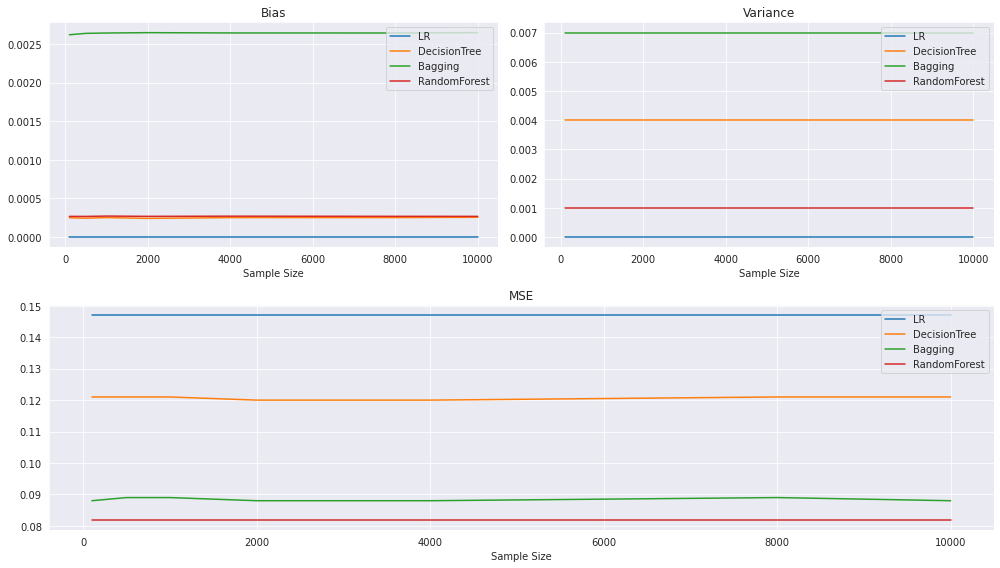

In [ ]:
# Plotting the obtained results
fig = plt.figure(figsize=(14,8))
layout = (2, 2)

ax0 = plt.subplot2grid(layout, (0, 0))
ax0.title.set_text('Bias')

temp = bias_variance_result[bias_variance_result['algorithm'] == 'LR']
ax0.plot(temp.sample_count, temp.bias)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'DecisionTree']
ax0.plot(temp.sample_count, temp.bias)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'Bagging']
ax0.plot(temp.sample_count, temp.bias)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'RandomForest']
ax0.plot(temp.sample_count, temp.bias)

ax0.legend(['LR','DecisionTree','Bagging','RandomForest'], loc=1)
ax0.set_xlabel('Sample Size')

ax1 = plt.subplot2grid(layout, (0, 1))
ax1.title.set_text('Variance')

temp = bias_variance_result[bias_variance_result['algorithm'] == 'LR']
ax1.plot(temp.sample_count, temp.variance)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'DecisionTree']
ax1.plot(temp.sample_count, temp.variance)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'Bagging']
ax1.plot(temp.sample_count, temp.variance)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'RandomForest']
ax1.plot(temp.sample_count, temp.variance)

ax1.legend(['LR','DecisionTree','Bagging','RandomForest'], loc=1)
ax1.set_xlabel('Sample Size')


ax2 = plt.subplot2grid(layout, (1, 0), colspan=2)
ax2.title.set_text('MSE')

temp = bias_variance_result[bias_variance_result['algorithm'] == 'LR']
ax2.plot(temp.sample_count, temp.mse)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'DecisionTree']
ax2.plot(temp.sample_count, temp.mse)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'Bagging']
ax2.plot(temp.sample_count, temp.mse)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'RandomForest']
ax2.plot(temp.sample_count, temp.mse)

ax2.legend(['LR','DecisionTree','Bagging','RandomForest'], loc=1)
ax2.set_xlabel('Sample Size')


plt.tight_layout()

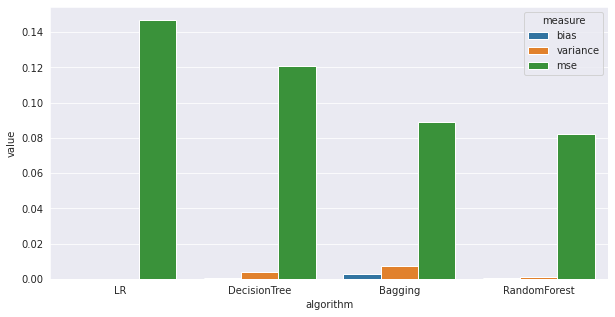

In [ ]:
df = bias_variance_result[bias_variance_result['sample_count'] == 8000][['algorithm','bias','variance','mse']]

t = pd.DataFrame(columns=['algorithm', 'measure', 'value'])
for measure in ['bias','variance','mse']:
    values = df[measure].values
    algos = df['algorithm'].values
    for i in range (0,len(values)):
        t = t.append(pd.Series(data={'algorithm':algos[i],'measure':measure, 'value' : values[i]},name =0))

plt.figure(figsize=(10,5))
sns.barplot(x='algorithm', y='value', hue='measure', data=t)

It could be observed that the increase in the sample size aids in a decrease in Bias and Variance. But often it is quite expensive to obtain data with a higher sample size.   
So, increasing the sample size might not be a viable solution for reducing the bias and variance of the model.

The computation of Bias and Variance of a model is not feasible in an ideal scenario.  
By experimenting in a controlled environment helped us realize the model’s (Linear Regression, Decision Tree, Bagging Decision Tree, Random Forest) behavior w.r.t various sample sizes of data.

**High sample sizes and if the same is a good representation of the population will help us obtain the required bias-variance trade-off point.**  
Observation of variation in bias and variance for different values of alpha in Ridge regression.

# Conclusion:

The main idea behind random forest is that lots of high variance and low bias trees combine to generate a low bias low variance forest.   
Since it is distibuted over different trees and each tree sees different set of data, therefore random forest in general do not over fit.  
And since they are made of low bias trees, underfitting also does not happen.


Reference 
- https://github.com/aaqibqadeer/Hotel-booking-demand
- https://www.kaggle.com/jessemostipak/hotel-booking-demand
- https://www.kaggle.com/code/rubenpv/exercise-hotel-booking-analysis
- https://www.kaggle.com/code/annikadhyani/hotel-booking-demand-analysis
- https://www.kaggle.com/code/alexanderwoo1982/hotel-bookings-data-exploration
- https://www.analyticsvidhya.com/blog/2020/12/a-measure-of-bias-and-variance-an-experiment/
- https://medium.com/analytics-vidhya/exploratory-data-analysis-of-the-hotel-booking-demand-with-python-200925230106
- https://towardsdatascience.com/machine-learning-project-predicting-boston-house-prices-with-regression-b4e47493633d